In [1]:
# !pip list

In [2]:
# !pip install diffusers==0.16.1

In [3]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]='0'
os.environ["HF_HOME"]="~/codes/.cache/huggingface"

In [4]:
import pickle

In [5]:
from accelerate.utils import ProjectConfiguration, set_seed

In [6]:
import torch
import random
import numpy as np

def set_seeds(seed):
    set_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seeds(42)

In [7]:
print(torch.__version__)

2.0.1+cu117


In [8]:
class Args():
    
    pretrained_model_name_or_path="lambdalabs/miniSD-diffusers"

    model_path = "./saved/5000-0.5/sd-lora"

    revision=None
    dataset_name=None
    
    gen_seed=0    
    gen_path = "./saved/5000-0.5/gen"
    
    resolution=256
    center_crop=True
    random_flip=False
    
    image_column='image'
    caption_column='label'
    
    seed=42
    max_train_samples=None


    train_batch_size=32
    dataloader_num_workers=0
    
    enable_xformers_memory_efficient_attention=False
    
    index_path = './data/indices/5000-0.5/idx_val.pkl'
args=Args()

In [9]:
# !pip install torchvision

In [10]:
from datasets import load_dataset
from torchvision import transforms

In [11]:
from transformers import CLIPTextModel, CLIPTokenizer

In [12]:
import diffusers
from diffusers import AutoencoderKL, DDPMScheduler, DDIMScheduler, DDIMInverseScheduler, DiffusionPipeline, UNet2DConditionModel
from diffusers.loaders import AttnProcsLayers
from diffusers.models.attention_processor import LoRAAttnProcessor
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available

In [13]:

DATASET_NAME_MAPPING = {
    "artbench": ("image", "label"),
}

# LABELS = ['art_nouveau', 'baroque', 'expressionism', 'impressionism', 'post_impressionism', 
#           'realism', 'renaissance', 'romanticism', 'surrealism', 'ukiyo_e']
# LABELS = [i.replace("_", " ").lower() for i in LABELS]


In [14]:
from packaging import version


In [15]:
from diffusers.utils import randn_tensor

In [16]:
if True:
    # If passed along, set the training seed now.
    if args.seed is not None:
        set_seeds(args.seed)

    # Load scheduler, tokenizer and models.
    noise_scheduler = DDPMScheduler.from_pretrained(args.pretrained_model_name_or_path, subfolder="scheduler",
                                                    local_files_only=True,
                                                    )
    ####
    ddim_noise_scheduler = DDIMScheduler.from_config(noise_scheduler.config)
    # ddim_inv_noise_scheduler = DDIMInverseScheduler.from_config(ddim_noise_scheduler.config)
    ####

    tokenizer = CLIPTokenizer.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="tokenizer", revision=args.revision,
                                                            local_files_only=True,)
    ####
    text_encoder = CLIPTextModel.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="text_encoder", revision=args.revision, local_files_only=True,
    )
    vae = AutoencoderKL.from_pretrained(args.pretrained_model_name_or_path, subfolder="vae", revision=args.revision, local_files_only=True,)
    unet = UNet2DConditionModel.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="unet", revision=args.revision, local_files_only=True,
    )
    # freeze parameters of models to save more memory
    unet.requires_grad_(False)
    vae.requires_grad_(False)

    text_encoder.requires_grad_(False)
    ####
    
    # For mixed precision training we cast the text_encoder and vae weights to half-precision
    # as these models are only used for inference, keeping weights in full precision is not required.
    weight_dtype = torch.float16
    # weight_dtype = torch.float32

    # Move unet, vae and text_encoder to device and cast to weight_dtype
    unet.to('cuda', dtype=weight_dtype)
    vae.to('cuda', dtype=weight_dtype)
    text_encoder.to('cuda', dtype=weight_dtype)

    # now we will add new LoRA weights to the attention layers
    # It's important to realize here how many attention weights will be added and of which sizes
    # The sizes of the attention layers consist only of two different variables:
    # 1) - the "hidden_size", which is increased according to `unet.config.block_out_channels`.
    # 2) - the "cross attention size", which is set to `unet.config.cross_attention_dim`.

    # Let's first see how many attention processors we will have to set.
    # For Stable Diffusion, it should be equal to:
    # - down blocks (2x attention layers) * (2x transformer layers) * (3x down blocks) = 12
    # - mid blocks (2x attention layers) * (1x transformer layers) * (1x mid blocks) = 2
    # - up blocks (2x attention layers) * (3x transformer layers) * (3x down blocks) = 18
    # => 32 layers

    # Set correct lora layers
    lora_attn_procs = {}
    for name in unet.attn_processors.keys():
        cross_attention_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim
        if name.startswith("mid_block"):
            hidden_size = unet.config.block_out_channels[-1]
        elif name.startswith("up_blocks"):
            block_id = int(name[len("up_blocks.")])
            hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
        elif name.startswith("down_blocks"):
            block_id = int(name[len("down_blocks.")])
            hidden_size = unet.config.block_out_channels[block_id]

        lora_attn_procs[name] = LoRAAttnProcessor(hidden_size=hidden_size, 
                                                  cross_attention_dim=cross_attention_dim,
                                                  rank=128
                                                 )

    unet.set_attn_processor(lora_attn_procs)
    ####
    # for n, p in unet.named_parameters():
    #     if p.requires_grad==True:
    #         print(n)
    ####
    if args.enable_xformers_memory_efficient_attention:
        if is_xformers_available():
            import xformers

            xformers_version = version.parse(xformers.__version__)
            if xformers_version == version.parse("0.0.16"):
                logger.warn(
                    "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
                )
            # unet.enable_xformers_memory_efficient_attention()
            pass
        else:
            raise ValueError("xformers is not available. Make sure it is installed correctly")

    # lora_layers = AttnProcsLayers(unet.attn_processors)

    # Enable TF32 for faster training on Ampere GPUs,
    # cf https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices

    # Get the datasets: you can either provide your own training and evaluation files (see below)
    # or specify a Dataset from the hub (the dataset will be downloaded automatically from the datasets Hub).

    # In distributed training, the load_dataset function guarantees that only one local process can concurrently
    # download the dataset.
    # data_files={'train': [args.dataset_name], }
    # dataset = load_dataset('imagefolder', 
    #                data_files=data_files, 
    # )
    ####
    import pandas as pd
    # df = pd.read_csv('../artbench/ArtBench-10.csv')
    df = pd.DataFrame()
    df['name'] = ['{}.png'.format(i) for i in range(1000)]
    df['label'] = ['ukiyo_e']*500+['post_impressionism']*500
    
    df['path'] = df.apply(lambda x: "{}/{}".format(
            args.gen_path,
            # x['label'], 
            x['name']), axis=1)
    # print(df.head())
    
    from datasets import DatasetDict, Dataset, load_dataset, Image
    
    dataset = DatasetDict({
        "train": Dataset.from_dict({
            "image": df['path'].tolist(),
            "label": df['label'].tolist(),
            "idx": list(range(1000)),
        }).cast_column("image", Image())
        ,})
    ####
    # new_column = [9] * len(dataset['train'])
    # dataset['train'] = dataset['train'].add_column("label", new_column)
    ####

    # Preprocessing the datasets.
    # We need to tokenize inputs and targets.
    column_names = dataset["train"].column_names

    # 6. Get the column names for input/target.
    dataset_columns = DATASET_NAME_MAPPING.get(args.dataset_name, None)
    if args.image_column is None:
        image_column = dataset_columns[0] if dataset_columns is not None else column_names[0]
    else:
        image_column = args.image_column
        if image_column not in column_names:
            raise ValueError(
                f"--image_column' value '{args.image_column}' needs to be one of: {', '.join(column_names)}"
            )
    if args.caption_column is None:
        caption_column = dataset_columns[1] if dataset_columns is not None else column_names[1]
    else:
        caption_column = args.caption_column
        if caption_column not in column_names:
            raise ValueError(
                f"--caption_column' value '{args.caption_column}' needs to be one of: {', '.join(column_names)}"
            )

    # Preprocessing the datasets.
    # We need to tokenize input captions and transform the images.
    def tokenize_captions(examples, is_train=True):
        captions = []
        for caption in examples[caption_column]:
            ####
            caption = 'a {} painting'.format(caption.replace("_", " ").lower())
            ####
            if isinstance(caption, str):
                captions.append(caption)
            elif isinstance(caption, (list, np.ndarray)):
                # take a random caption if there are multiple
                captions.append(random.choice(caption) if is_train else caption[0])
            else:
                raise ValueError(
                    f"Caption column `{caption_column}` should contain either strings or lists of strings."
                )
        inputs = tokenizer(
            captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
        )
        return inputs.input_ids

    # Preprocessing the datasets.
    train_transforms = transforms.Compose(
        [
            transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(args.resolution) if args.center_crop else transforms.RandomCrop(args.resolution),
            transforms.RandomHorizontalFlip() if args.random_flip else transforms.Lambda(lambda x: x),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

    def preprocess_train(examples):
        images = [image.convert("RGB") for image in examples[image_column]]
        examples["pixel_values"] = [train_transforms(image) for image in images]
        examples["input_ids"] = tokenize_captions(examples)
        
        return examples

    # Set the training transforms
    train_dataset = dataset["train"]
    ####
    train_dataset = train_dataset.with_transform(preprocess_train)
    print(len(train_dataset))
    print(train_dataset[0])
    ####

#     def collate_fn(examples):
#         pixel_values = torch.stack([example["pixel_values"] for example in examples])
#         pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
#         input_ids = torch.stack([example["input_ids"] for example in examples])
#         return {"pixel_values": pixel_values, "input_ids": input_ids}

    def collate_fn(examples):
        pixel_values = torch.stack([example["pixel_values"] for example in examples])
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
        
        input_ids_list = []
        for example in examples:
            input_ids_list.append(example["input_ids"])

        input_ids = torch.stack(input_ids_list)
        
        idx = [example['idx'] for example in examples]

        return {"pixel_values": pixel_values, 
                "input_ids": input_ids,
                "idx": idx,
               }

    # DataLoaders creation:
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        shuffle=False,
        collate_fn=collate_fn,
        batch_size=args.train_batch_size,
        num_workers=args.dataloader_num_workers,
    )

1000
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7F268447B340>, 'label': 'ukiyo_e', 'idx': 0, 'pixel_values': tensor([[[ 0.0510,  0.3098,  0.2235,  ...,  0.6157,  0.6157,  0.6549],
         [ 0.0118,  0.1765,  0.1608,  ...,  0.6157,  0.6235,  0.6549],
         [-0.0745,  0.0902,  0.2000,  ...,  0.6235,  0.6314,  0.6706],
         ...,
         [ 0.2157,  0.2314,  0.1922,  ...,  0.6000,  0.6157,  0.6314],
         [ 0.2000,  0.2941,  0.2471,  ...,  0.6235,  0.6078,  0.6314],
         [ 0.2235,  0.1137,  0.2392,  ...,  0.6314,  0.6471,  0.6627]],

        [[-0.4275, -0.3098, -0.5059,  ...,  0.5137,  0.5137,  0.5451],
         [-0.6235, -0.5686, -0.5686,  ...,  0.5216,  0.5137,  0.5216],
         [-0.8510, -0.7255, -0.5765,  ...,  0.5294,  0.5294,  0.5451],
         ...,
         [ 0.2941,  0.3569,  0.3098,  ...,  0.4667,  0.4431,  0.4353],
         [ 0.2314,  0.3725,  0.3647,  ...,  0.4667,  0.4588,  0.4431],
         [ 0.2157,  0.1843,  0.3176,  ...,  0.4

In [17]:
len(train_dataset)

1000

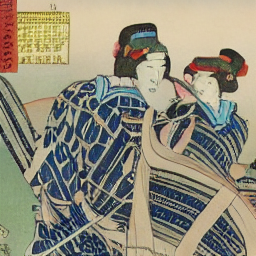

In [18]:
dataset["train"][0]['image']

In [19]:
import torch.nn.functional as F
from torch.func import functional_call, vmap, grad

In [20]:
len(train_dataset)

1000

In [21]:
empty_inputs = tokenizer([''], 
               padding="max_length", 
               max_length=tokenizer.model_max_length, 
               truncation=True, 
               return_tensors='pt')
empty_inputs.input_ids
empty_hidden_states_ = text_encoder(empty_inputs.input_ids.cuda())[0]
empty_hidden_states_.shape

torch.Size([1, 77, 768])

In [22]:
total = len(train_dataset)
total

1000

In [23]:
args.gen_seed

0

In [24]:
import einops

In [25]:
if True:
    # Scheduler and math around the number of training steps.
    if True:
        set_seeds(42)
        model_path = './saved/5000-0.5/sd-lora'
        unet.load_attn_procs(model_path)
        unet.eval()
        ####
        vae.eval()
        text_encoder.eval()
        ####
        K = 50
        ####
        ddim_noise_scheduler.set_timesteps(K, device='cuda')
        ddim_noise_scheduler_timesteps = ddim_noise_scheduler.timesteps
        print(ddim_noise_scheduler_timesteps)
        ####
        dstore_keys = np.memmap('./saved/5000-0.5/gen/sd_gen_latents.npy', 
                                dtype=np.float32, 
                                mode='w+', 
                                shape=(len(train_dataset), 
                                       K, 
                                       4, 32, 32)
                               )
        ####
        for step, batch in enumerate(train_dataloader):
            set_seeds(42)
            for key in batch.keys():
                if key!='idx':
                    batch[key] = batch[key].cuda()
            
            # Skip steps until we reach the resumed step
            # latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.mode()
            # latents = latents * vae.config.scaling_factor
            
            bsz = batch["input_ids"].shape[0]
            encoder_hidden_states = text_encoder(batch["input_ids"])[0]
            ####
            empty_hidden_states = einops.repeat(empty_hidden_states_, '1 L D -> B L D', B=bsz)
            print(empty_hidden_states.size())
            ####
            if True:
                ####
                i = step*args.train_batch_size
                print(i)
                print([i+j for j in range(bsz)])

                generator = [torch.Generator('cpu').manual_seed(args.gen_seed*total+i+j) for j in range(bsz)]
                ####
                latents = randn_tensor((len(generator), 4, 32, 32), generator=generator, dtype=torch.float16) 
                latents = latents * ddim_noise_scheduler.init_noise_sigma
                latents = latents.cuda()
                ####
                for index_t, t in enumerate(ddim_noise_scheduler_timesteps[:]):
                    latent_model_input = torch.cat([latents] * 2)

                    with torch.no_grad():
                        noise_pred = unet(latent_model_input, t, 
                                               torch.cat([empty_hidden_states, encoder_hidden_states], dim=0)
                                              ).sample
                        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                        noise_pred = noise_pred_uncond + 7.5 * (noise_pred_text - noise_pred_uncond)

                    prev_timestep = t - ddim_noise_scheduler.config.num_train_timesteps // ddim_noise_scheduler.num_inference_steps
                    # print(index_t, t, prev_timestep)
                    ####
                    alpha_prod_t = ddim_noise_scheduler.alphas_cumprod[t]
                    alpha_prod_t_prev = (
                        ddim_noise_scheduler.alphas_cumprod[prev_timestep]
                        if prev_timestep >= 0
                        else ddim_noise_scheduler.final_alpha_cumprod
                    )
                    beta_prod_t = 1 - alpha_prod_t
                    ####
                    pred_original_sample = (latents - beta_prod_t ** (0.5) * noise_pred) / alpha_prod_t ** (0.5)
                    pred_epsilon = noise_pred
                    pred_sample_direction = (1 - alpha_prod_t_prev) ** (0.5) * pred_epsilon
                    prev_sample = alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction
                    ####
                    dstore_keys[step*args.train_batch_size:step*args.train_batch_size+bsz, 
                                 index_t] = pred_original_sample.cpu().numpy()
                    latents = prev_sample.half()
                    ####                
                print(step, 0, t)
                print(step*args.train_batch_size, step*args.train_batch_size+bsz)
            # break

tensor([981, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741, 721,
        701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461, 441,
        421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181, 161,
        141, 121, 101,  81,  61,  41,  21,   1], device='cuda:0')
torch.Size([32, 77, 768])
0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
0 0 tensor(1, device='cuda:0')
0 32
torch.Size([32, 77, 768])
32
[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
1 0 tensor(1, device='cuda:0')
32 64
torch.Size([32, 77, 768])
64
[64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
2 0 tensor(1, device='cuda:0')
64 96
torch.Size([32, 77, 768])
96
[96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 1

In [26]:
# dstore_keys[-5:]

In [27]:
dstore_keys.shape

(1000, 50, 4, 32, 32)

In [28]:
ddim_noise_scheduler.init_noise_sigma

1.0

In [31]:
from diffusers import StableDiffusionPipeline, DDIMScheduler, DDIMInverseScheduler, StableDiffusionPix2PixZeroPipeline
import torch

# load models
model_id = "lambdalabs/miniSD-diffusers"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.unet.load_attn_procs("./saved/5000-0.5/sd-lora/")

pipe.to("cuda")
print('done')

text_encoder/model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


done


In [112]:
i=-1

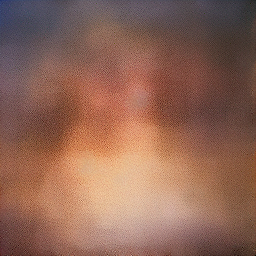

In [113]:
with torch.no_grad():
    tmp = pipe.decode_latents(torch.from_numpy(dstore_keys[i]).cuda().half())
    tmp = pipe.numpy_to_pil(tmp)
tmp[0]

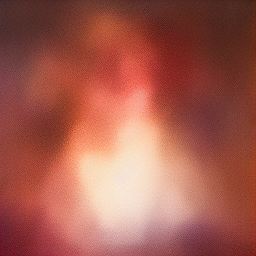

In [114]:
tmp[5]

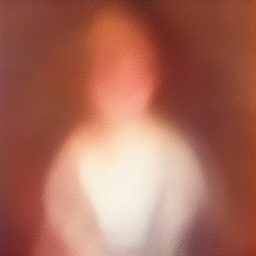

In [115]:
tmp[10]

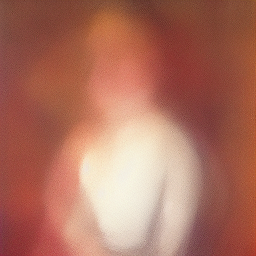

In [116]:
tmp[15]

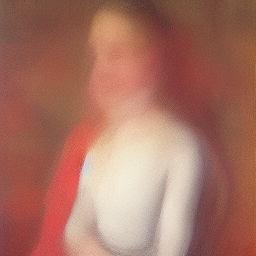

In [117]:
tmp[20]

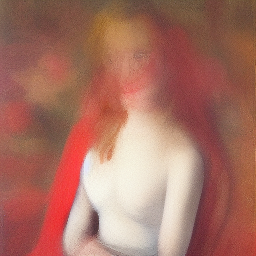

In [118]:
tmp[25]

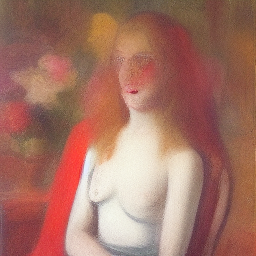

In [119]:
tmp[30]

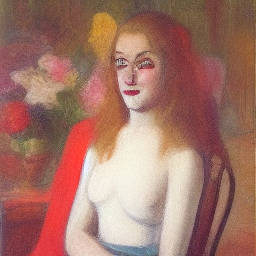

In [120]:
tmp[35]

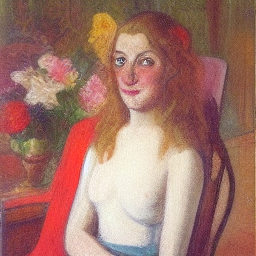

In [121]:
tmp[40]

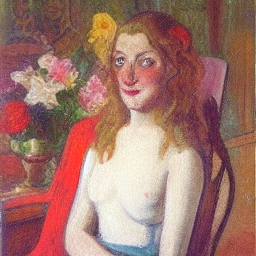

In [122]:
tmp[45]

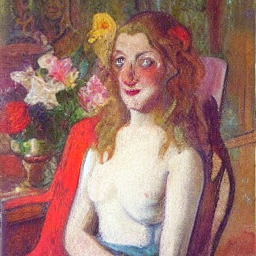

In [123]:
tmp[-1]

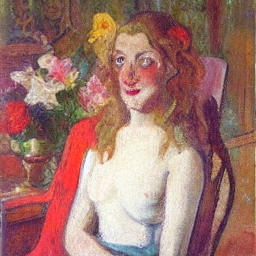

In [124]:
dataset["train"][i]['image']